## [**Robust Principal Component Analysis for everyone**](https://freshprinceofstandarderror.com/ai/robust-principal-component-analysis/)

Most people have heard of Principal Component Analysis. It was the last thing I learned and perhaps many people learn in their introductory linear algebra course at university. I’ve had to use it plenty of times to reduce dimensions when staring at a dataset with too many columns. Many people are satisfied with vanilla PCA and rightly so.

If you aren’t familiar then it is a linear transformation to transform high dimensional data to a new coordinate system with the first principal component explaining the most variance. Principal components are found by computing the eigenvalues and eigenvectors of the co-variance matrix. Reducing data still comes at the cost of accuracy but doing this allows a person to capture most of the variance.

Other interesting things about principal components

- Principal components are uncorrelated with one another by design
- They are linear combinations of the original columns
- They capture most of the variance, with the first PC capturing the most variance and so on.

If you’ve never heard of PCA then review it before getting into RPCA.

### **What is the problem with PCA?**
The problem with PCA is that outliers have can have the effect of tilting and stretching your factor. Outliers and corrupt values exist in a lot of financial data but also in user data that product managers might use with dimensionality reduction. Unfortunately, outliers and too much noise or corruption will skew the distribution of your vanilla PC(A).

<center> <p>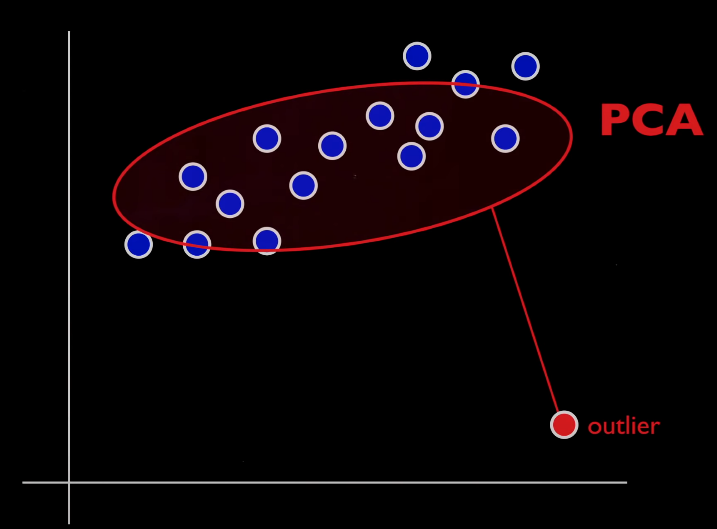</p> </center>

### **Should I be using RPCA?**
Ask yourself whether you already have enough information about the true distribution. It’s much simpler if you do otherwise try out some other form of PCA which penalises the L1 norm along with trying this out. If your problem is outliers and corrupt data then RPCA might still be a pretty good choice.

<center> <p>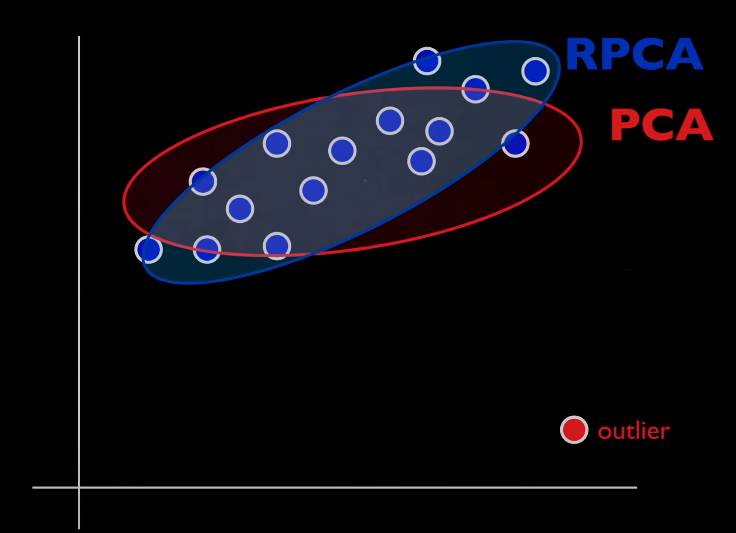</p> </center>

Imagine how penalising L1 norm in regression fixes your outlier problem rather than using square root of the sum of the squared vector values. When you understand this, then you already have the intuition. If you don’t get it then don’t worry, the following explanation along with a little research into Lasso regression in your spare time will help.

The L1 norm is the sum of `|absolute difference|` among all the components therefore it is weighted equally. Unlike using squared difference which will give outliers greater weight (by squaring them). Targeting the absolute value of magnitude via a cost function is less susceptible to outliers. RPCA tries to minimise the nuclear norm and L1 norm of respective matrices that make up your data, more on this later.

#### **How to RPCA math?**
If you have a high dimensional dataset with anomalies then it would be ideal to **split the matrix into a linear combination of a sparse matrix with outliers and another matrix with data that is closer to the correct distribution**.

$$
    \text {High Dimensional Matrix} = \text {Data Matrix} + \text {Outlier Matrix}
$$

This isn’t an easy math problem though. <span style="color:red"> **There are infinitely many ways to split a matrix into two other matrixes so this problem is ill posed.** </span>.

People found that it is theoretically possible by finding a minimum rank data matrix and some sparse outlier matrix but it takes too long to compute. Researchers like Candès, Li and Ma proposed the following **convex relaxation**.

$$
    X = min ( ||L||_* + λ||S||_1 )
$$

X = Some high dimensional matrix  
L = Data matrix you hope to get  
S = Sparse matrix of noise and outliers  

$||L||_*$ = Nuclear norm of L, proxy for rank  
$λ = 1 / sqrt( max(n,m) )$, where n and m are the dimensions of X  
$||S||_1$ = L1 norm of S, helps make it sparse

### **Practical use of RPCA**

I read a solution to solving for the L and S from above would be using some Lagrange multipliers or using the alternating directions method (ADM) until the solution converges. ADM belongs in the general class of Lagrange multiplier algorithms.

While I’m no optimisation expert, I have tremendous expertise in implementing models from publications. The following is the MATLAB implementation by Washington University teacher, Steve Brunton.

<center> <p>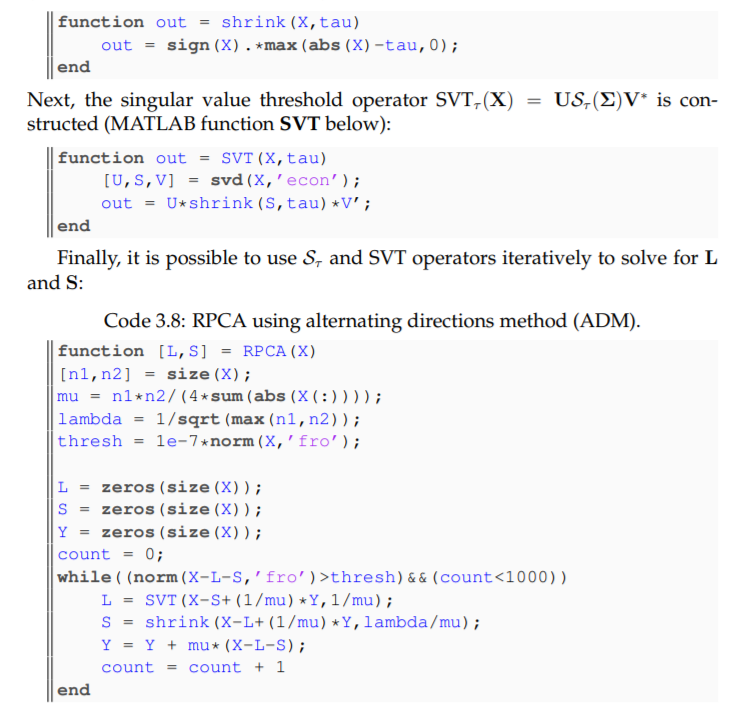</p> </center>

$$ \text {Matlab code from pg 124 of the Data-driven Science and Engineering book. Available for free on their website.} $$

### **RPCA example with images**

In this example we will use RPCA to split an image into two other matrices. Therefore we will need to download images and a package that will make it easier to read them in Python such as OpenCV.

```bash
    conda install -c conda-forge opencv
```

Images of people’s faces can be found in the Yale face dataset.  
http://vision.ucsd.edu/~iskwak/ExtYaleDatabase/ExtYaleB.html

Download the cropped images they provide to make life easier.  
http://vision.ucsd.edu/extyaleb/CroppedYaleBZip/CroppedYale.zip

Cool, now that we’re all prepared open up your jupyter notebook and import these packages and the following Python code.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv2

This is the correct implementation for RPCA in Python

In [2]:
#Python code provided by Data-driven Sci and Eng
def shrink(X,tau):
    Y = np.abs(X)-tau
    return np.sign(X) * np.maximum(Y,np.zeros_like(Y))

def SVT(X,tau):
    U,S,VT = np.linalg.svd(X,full_matrices=0)
    out = U @ np.diag(shrink(S,tau)) @ VT
    return out

def RPCA(X):
    n1,n2 = X.shape
    mu = n1*n2/(4*np.sum(np.abs(X.reshape(-1))))
    lambd = 1/np.sqrt(np.maximum(n1,n2))
    thresh = 10**(-7) * np.linalg.norm(X)
    
    S = np.zeros_like(X)
    Y = np.zeros_like(X)
    L = np.zeros_like(X)
    count = 0
    while (np.linalg.norm(X-L-S) > thresh) and (count < 1000):
        L = SVT(X-S+(1/mu)*Y,1/mu)
        S = shrink(X-L+(1/mu)*Y,lambd/mu)
        Y = Y + mu*(X-L-S)
        count += 1
    return L,S

### **A brief intro to images and computer vision**
Computers aren’t like us and can't understand images as we do. However, they understand matrices and we can use a matrix with different intensity values for each pixel to represent a grayscale image. Colour images have three additional channels such as RGB or some other standard.

I’ll be working with the first four images in the yaleB01 folder.

<center> <p>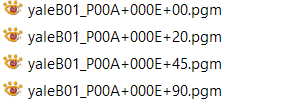</p> </center>

$$
    \text {Images used in this article from folder yaleB01}
$$

An image looks like this numpy array.

```python
img1 = cv2.imread('yaleB01_P00A+000E+00.pgm',cv2.IMREAD_GRAYSCALE)
plt.imshow(img1,'gray')

print(np.shape(img1))
img1
```
<center> <p>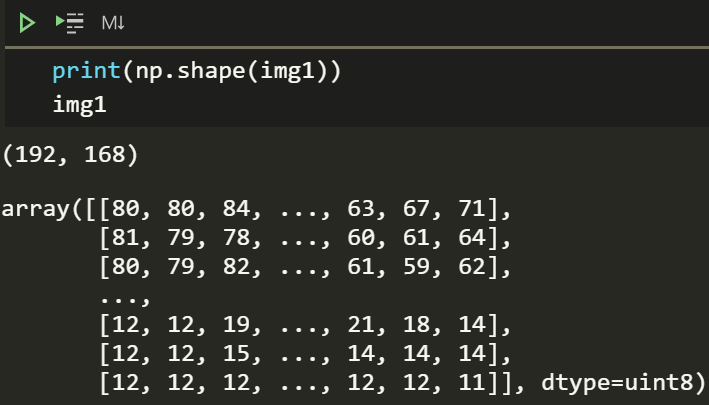</p> </center>


$$
    \text {Numpy array of a grayscale image}
$$

The image is 192*168 or 32256 pixels. The values can range between 0 and 255, darker to lighter. We can figure out how dark or light the image is by looking at its histogram.
```python
plt.hist(img1);
```

This image isn’t too dark or light but kind of in the middle.
<center> <p>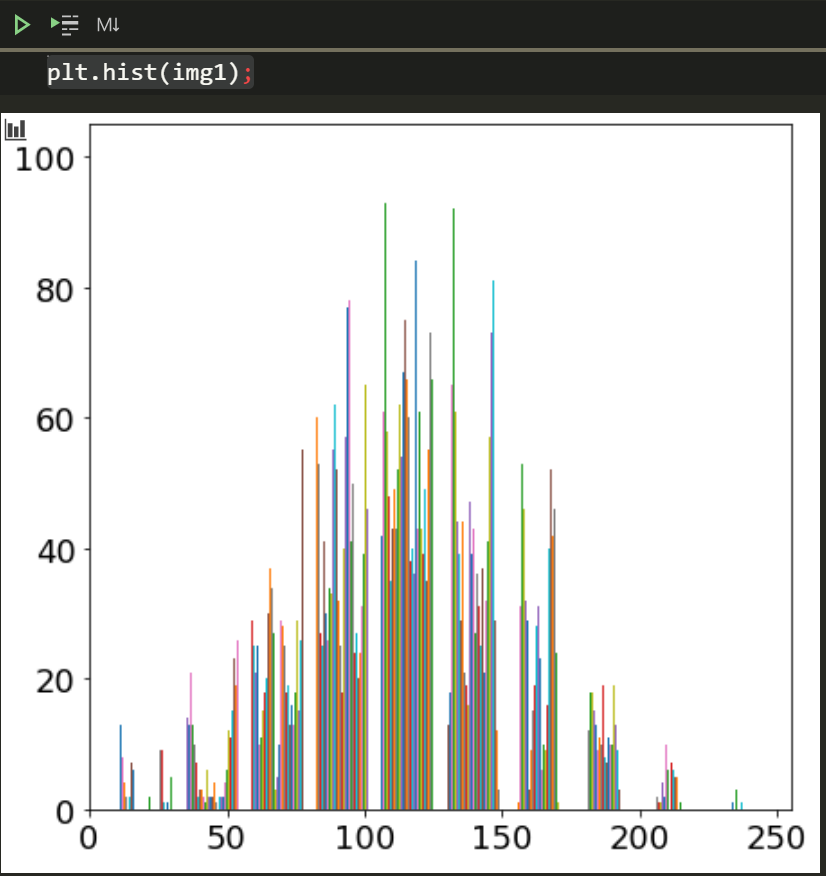</p> </center>

$$
    \text {Histogram of grayscale image}
$$

We can load additional images and see what their histograms look like (I don’t know yet either). I’ll write a simple function to make it easier to see the image along with the diagram.
```python
def img_hists(img):
    fig, ax = plt.subplots(2) 
    ax[0].imshow(img,'gray')
    ax[1].hist(img);
```

```python
img1 = cv2.imread('yaleB01_P00A+000E+00.pgm',cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('yaleB01_P00A+000E+20.pgm',cv2.IMREAD_GRAYSCALE)
img3 = cv2.imread('yaleB01_P00A+000E+45.pgm',cv2.IMREAD_GRAYSCALE)
img4 = cv2.imread('yaleB01_P00A+000E+90.pgm',cv2.IMREAD_GRAYSCALE)
```

```python
img_hists(img4)
```

<center> <p>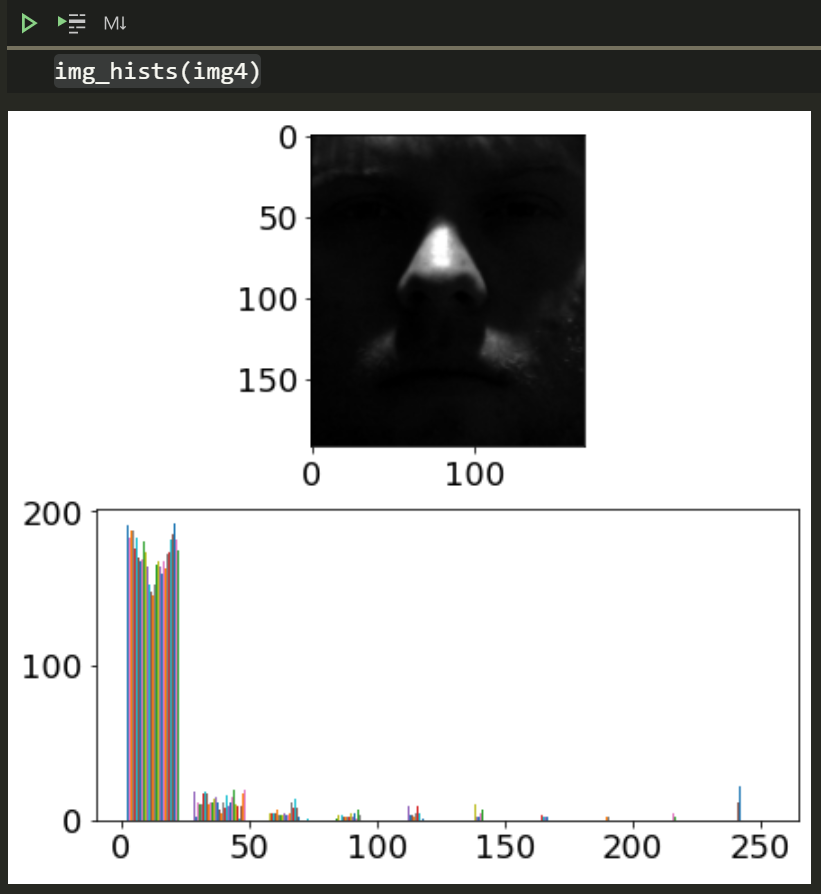</p> </center>

$$
    \text {A lot of values closer to 0}
$$

This histogram has many more values near 0 so it’s obviously darker as we can see.

### **Using RPCA to find outliers and / or bad values**
Pick one of the images and have a look at the histogram, we want to put some outliers in it. I picked the very first image.

<center> <p>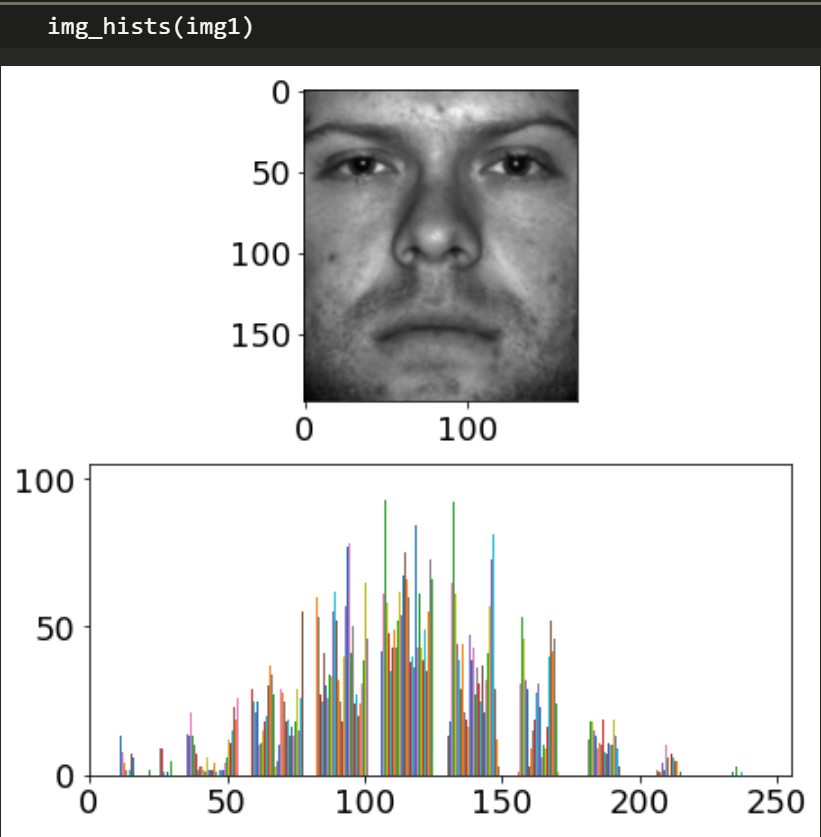</p> </center>

This image has fewer very dark and very light values. Lets add 3 black teardrops because this person must have murdered at least 3 people. You can use an image editor like GIMP or Photoshop. I’ll provide my .PNG here: https://imgur.com/dhb3vJi

```python
img_dot = cv2.imread('yaleB01_P00A+000E+00_dot.png',cv2.IMREAD_GRAYSCALE)
plt.imshow(img_dot,'gray')
```

```python
img_hists(img_dot)
```

<center> <p>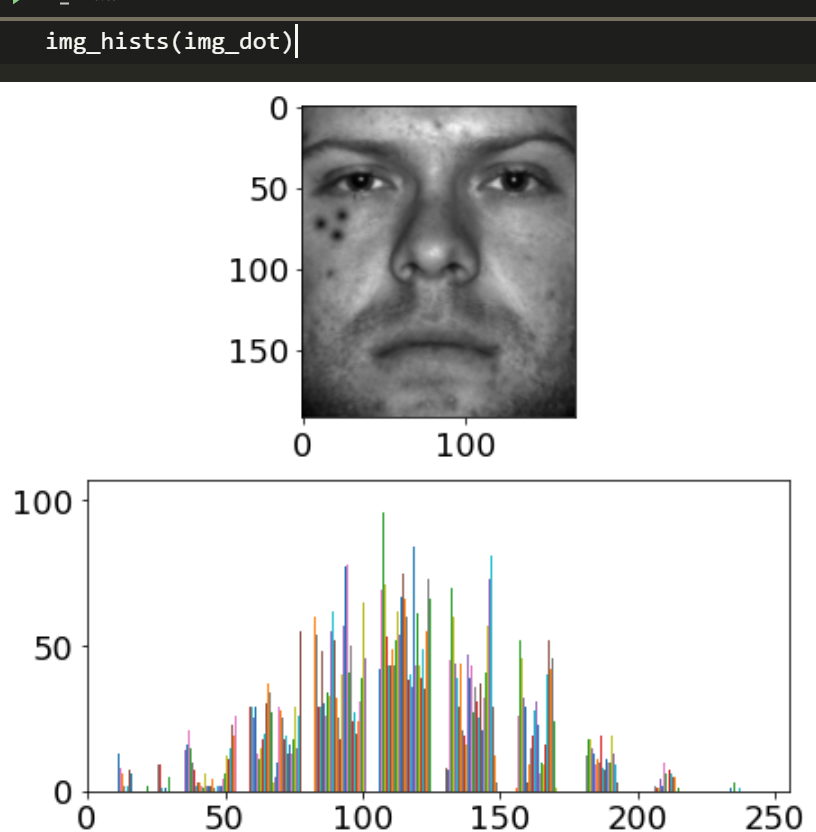</p> </center>

Lets try RPCA on it, and see how well it does.
```python
D_1, S_1 = RPCA(img_dot)
plt.imshow(D_1,'gray')
```

<center> <p>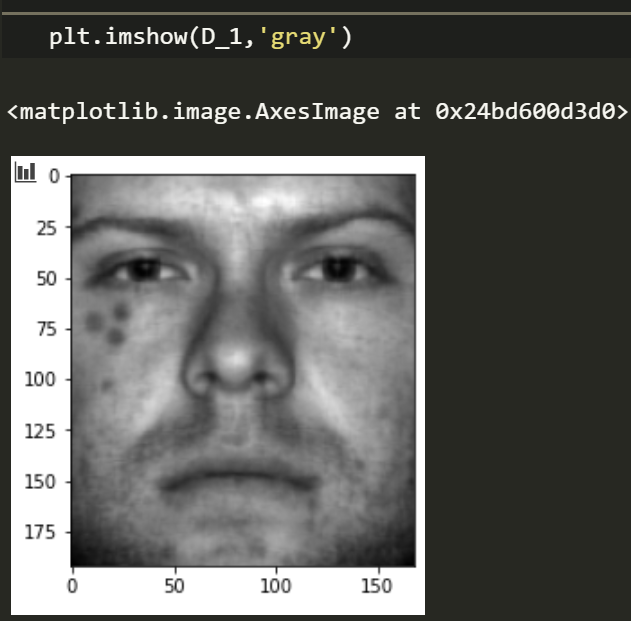</p> </center>

HEY! not too bad, we can already see some improvement. But what if we had a lot more data about the true distribution?
```python
imgs = np.concatenate([img1,img2,img3,img4,img_dot])
D, S = RPCA(imgs)

plt.imshow(D[-192:],'gray')
```

<center> <p>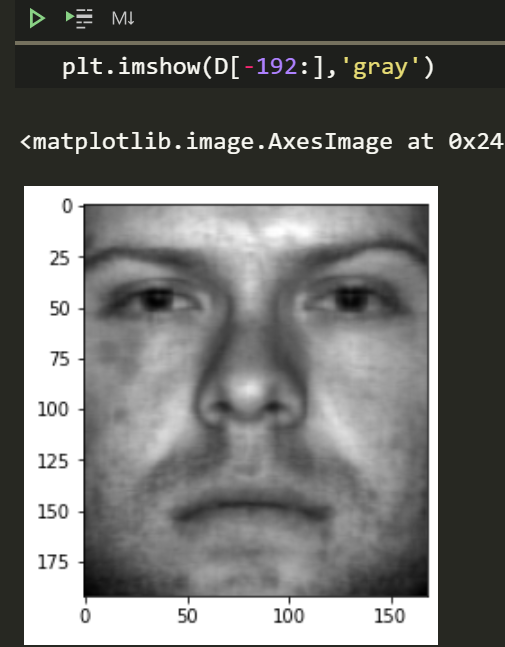</p> </center>

His murderous past is practically erased!

Lets quickly see how the high dimensional data was split into a linear combination of two matrices. Looking at the sparse outlier matrix is interesting too.
```python
ffig, ax = plt.subplots(1,3,figsize=(6,10))
plt.title('Matrix split into X = D+S')
ax[0].imshow(D,'gray')
ax[1].imshow(S,'gray')
ax[2].imshow(D+S,'gray')
```

<center> <p>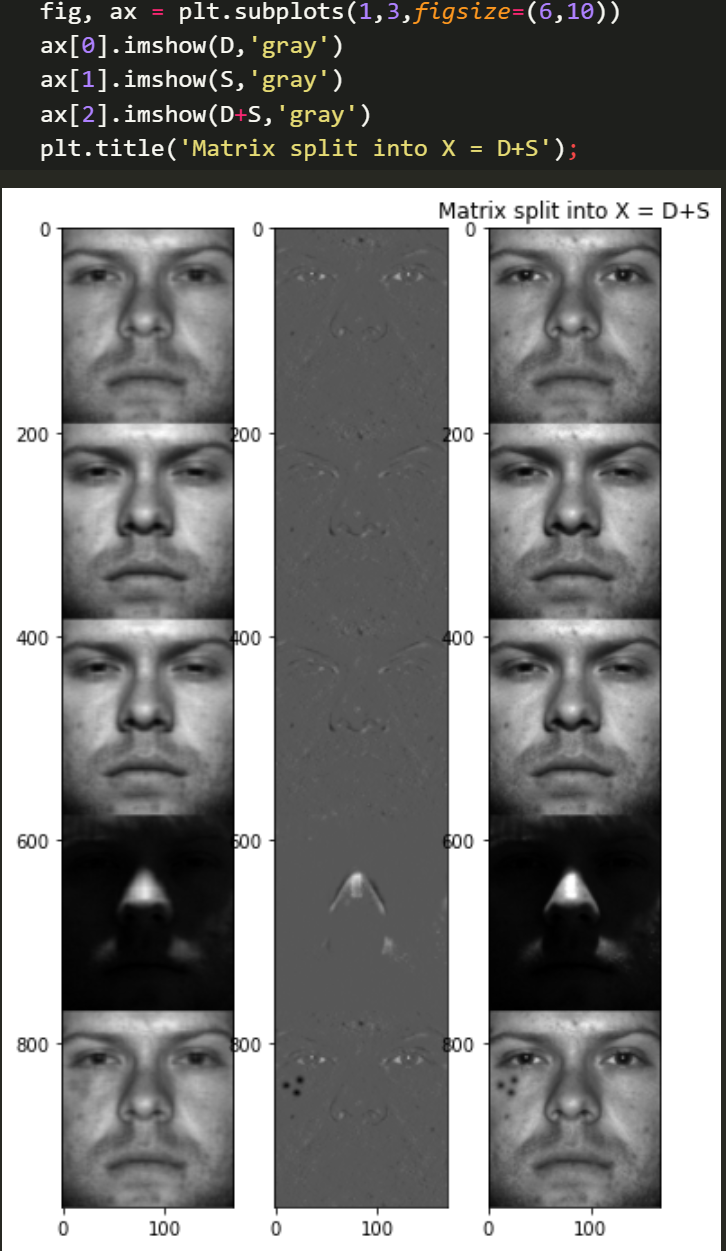</p> </center>

PS: This dude is likely a yale student or maybe a researcher, not a murderer for those who needed clarification.

- What you learned
- Main idea behind PCA
- Why PCA has outliers
- How minimising nuclear and L1 norms for the respective matrices can improve your principal components
- How to think flexibly about RPCA, such as removing outliers from images

Amazing work, now go forth and experiment.